               
q_0: ──────────
               
q_1: ──■───────
       │       
q_2: ──┼───────
       │       
q_3: ──┼────■──
       │    │  
q_4: ──┼────┼──
     ┌─┴─┐┌─┴─┐
q_5: ┤ X ├┤ X ├
     └───┘└───┘
     ┌───┐     ┌──────────────┐┌───┐┌─┐            
q_0: ┤ H ├─────┤0             ├┤ H ├┤M├────────────
     ├───┤     │              │├───┤└╥┘┌─┐         
q_1: ┤ H ├─────┤1             ├┤ H ├─╫─┤M├─────────
     ├───┤     │              │├───┤ ║ └╥┘┌─┐      
q_2: ┤ H ├─────┤2             ├┤ H ├─╫──╫─┤M├──────
     ├───┤     │  circuit-176 │├───┤ ║  ║ └╥┘┌─┐   
q_3: ┤ H ├─────┤3             ├┤ H ├─╫──╫──╫─┤M├───
     ├───┤     │              │├───┤ ║  ║  ║ └╥┘┌─┐
q_4: ┤ H ├─────┤4             ├┤ H ├─╫──╫──╫──╫─┤M├
     ├───┤┌───┐│              │└───┘ ║  ║  ║  ║ └╥┘
q_5: ┤ X ├┤ H ├┤5             ├──────╫──╫──╫──╫──╫─
     └───┘└───┘└──────────────┘      ║  ║  ║  ║  ║ 
c: 5/════════════════════════════════╩══╩══╩══╩══╩═
                                     0  1  2  3  4 
Counts: {'01

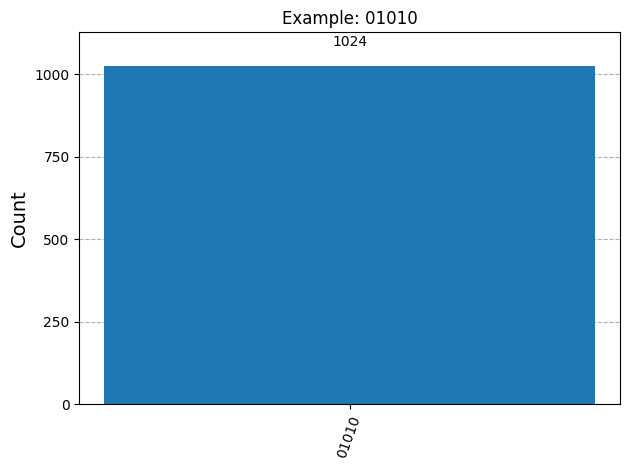

In [2]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

# Deutsch-Josa algorithm circuit
def deutsch_josa_algorithm(oracle, n: int):
    qc = QuantumCircuit(n + 1, n)
    qc.x(n) # Initialize the ancilla qubit to |1>
    qc.h(list(range(n + 1))) # Apply Hadamard gates to all qubits
    qc.append(oracle, range(n + 1))  # Apply oracle
    qc.h(list(range(n))) # Apply Hadamard gates to all qubits
    qc.measure(range(n), range(n))
    return qc

# Berstein-Vazirani oracle generator
def berstein_vazirani_oracle(case: str, n: int):
    qc = QuantumCircuit(n + 1)
    for i in range(len(case)):
        if case[i] == '1':
            qc.cx(i, n)
    return qc

# Example usage
n = 5  # Number of qubits
case = "01010"

oracle = berstein_vazirani_oracle(case, n)
qc = deutsch_josa_algorithm(oracle, n)
print(oracle.draw("text"))
print(qc.draw("text"))

# Run on simulator
sim = Aer.get_backend("aer_simulator")
tqc = transpile(qc, sim)
result = sim.run(tqc, shots = 1024).result()
counts = result.get_counts()
print("Counts:", counts)
plot_histogram(counts, title="Example: "+ case)

As, expected Deutsch-Josa circuit solves Berstein-Vazirani problem in one query and finds it with 100% accuracy.